In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_excel("Данные.xlsx")
data = data.rename(columns={"дата": "date", "направление": "dir", "выход": "out"}).set_index("date")
data = data.iloc[::-1]
data.head()

,dir,out
date,,
2018-01-04,ш,67.67
2018-01-05,л,68.78
2018-01-09,ш,69.06
2018-01-10,ш,69.15
2018-01-11,л,69.86


In [3]:
result_df = pd.read_excel("Данные.xlsx", sheet_name=1, index_col=0)
result_df.head()

,направление,выход
дата,,
2022-01-03,NaN,NaN
2022-01-04,NaN,NaN
2022-01-05,NaN,NaN
2022-01-06,NaN,NaN
2022-01-07,NaN,NaN


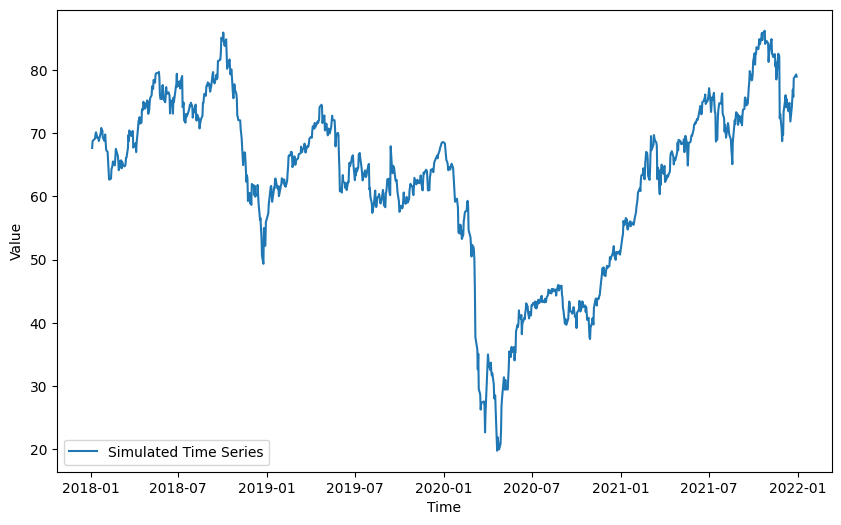

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data["out"], label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [5]:
adfuller(data["out"], regression="ctt")

(-2.478181275068254,
 0.5818124192895627,
 0,
 1000,
 {'1%': -4.382754353047, '5%': -3.838308308284, '10%': -3.556924956559},
 3422.9409938842805)

Можно заметить, что это ряд типа DSP, который нужно остационаривать процедурой взятия разностей.

<Figure size 1000x600 with 0 Axes>

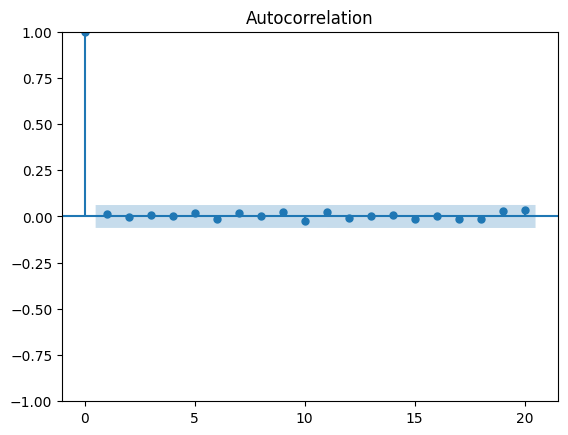

<Figure size 1000x600 with 0 Axes>

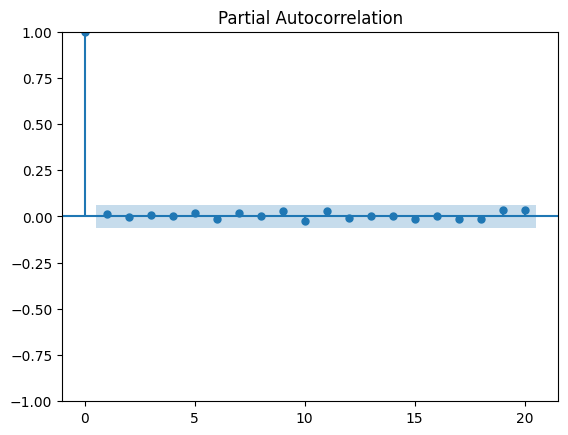

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(data.out.diff(1).dropna(), lags=20)
plt.show()

# Plot Partial Autocorrelation (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(data.out.diff(1).dropna(), lags=20, method='ywm')
plt.show()

Можно заметить, что моделирование первых разностей напоминает белый шум.

### Статистическая модель

In [7]:
data.index = data.index.to_period('d')

In [8]:
train_size = int(0.8 * data.shape[0])
train, test = data["out"].iloc[:train_size], data["out"].iloc[train_size:]

In [9]:
def stl_grid_seach(series, periods):
    # Define the ranges for the parameters you want to explore
    seasonal_range = range(7, 24, 2)  # Example: 7 to 23, stepping by 2
    trend_range = [sr + 90 + 1 for sr in stl_range]  # Example: 15 to 55, stepping by 5

    best_params = None
    best_criteria = float('inf')  # or -float('inf') depending on the criteria (lower is better or higher is better)

    for period in periods:
        for seasonal_length in seasonal_range:
            for trend_length in trend_range:
                if trend_length <= seasonal_length:
                    continue  # Ensure trend_length > seasonal_length
                try:
                    # Perform STL Decomposition with current parameters
                    stl = STL(series, period=period, seasonal=seasonal_length, trend=trend_length, robust=True)
                    result = stl.fit()

                    # Define your evaluation criteria
                    # For simplicity, let's say we're using the standard deviation of the residual
                    # Your criteria might be different based on your goals
                    criteria = np.std(result.resid)

                    if criteria < best_criteria:  # Assuming lower residual std is better
                        best_criteria = criteria
                        best_params = (seasonal_length, trend_length, period)

                except Exception as e:
                    print(f"Error with parameters seasonal={seasonal_length}, trend={trend_length}: {e}")
                    continue
    return best_params, best_criteria


stl_range = [92, 160, 270]
best_params, best_score = stl_grid_seach(train, stl_range)

Error with parameters seasonal=7, trend=183: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=7, trend=251: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=9, trend=183: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=9, trend=251: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=11, trend=183: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=11, trend=251: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=13, trend=183: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=13, trend=251: trend must be an odd positive integer >= 3 where trend > period
Error with parameters seasonal=15, trend=183: trend must be an odd positive integer >= 3 where trend > period
Error with par

In [10]:
def stl_arima_grid_search(data, test, p_range, d_range, q_range, stl_range, trend_range, seasonal_period, criterion='aic'):
    """
    Perform a grid search to find the best ARIMA model parameters after STL decomposition,
    based on the AIC or BIC criterion.

    Parameters:
    - data: The time series data.
    - p_range, d_range, q_range: Ranges of parameters (p, d, q) for the ARIMA component.
    - seasonal_period: The seasonal period for STL decomposition.
    - criterion: 'aic' for Akaike Information Criterion or 'bic' for Bayesian Information Criterion.

    Returns:
    - A tuple containing the best parameters and the corresponding AIC or BIC value.
    """
    
    best_score, best_cfg = float("inf"), None
    
    for p, d, q, period, trend in itertools.product(p_range, d_range, q_range, stl_range, trend_range):
        try:
            stl = STLForecast(
                train,
                ARIMA,
                model_kwargs=dict(order=(p, d, q), trend=None),
                period=period,
                robust=False,
                seasonal=13, 
                trend=trend
            )

            result = stl.fit()
            forecasted = result.get_prediction(start=len(data), end=len(data) + len(test) - 1).predicted_mean.to_list()
            
            if criterion == 'aic':
                score = result.model_result.aic
            if criterion == 'mse':
                score = mean_squared_error(test, forecasted)
            else: # 'bic'
                score = result.model_result.bic
                
            if score < best_score:
                best_score, best_cfg = score, {"order": (p, d, q), "period": period, "trend": trend}
                print('ARIMA%s %s=%.3f' % ((p, d, q), criterion.upper(), score))
        except:
            continue

    print(f'Best ARIMA{best_cfg} {criterion.upper()}={best_score:.3f}')
    return best_cfg, best_score


# Define the range of parameters to search
p_range = range(0, 4)
d_range = range(0, 5)
q_range = range(0, 4)
stl_range = [92]
trend_range = [int(365 / 2), 365]
seasonal_period = 7  # Assuming a yearly seasonality

# Find the best model based on AIC
best_params, best_score = stl_arima_grid_search(train, test, p_range, d_range, q_range, stl_range, trend_range, seasonal_period, 'mse')


ARIMA(0, 0, 0) MSE=223.185


/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 2) MSE=92.897


/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 3, 3) MSE=88.508


/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/s

ARIMA(1, 3, 2) MSE=64.248


/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/root/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWar

Best ARIMA{'order': (1, 3, 2), 'period': 92, 'trend': 365} MSE=64.248


/root/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3308.128863774544


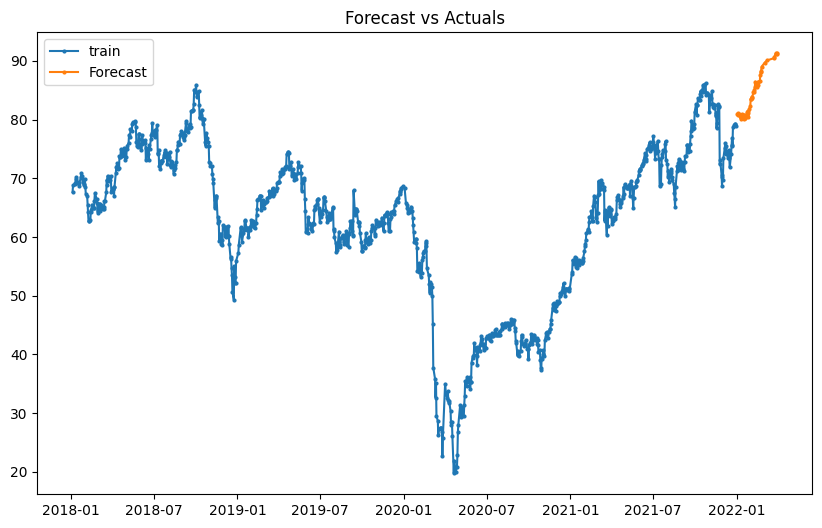

In [11]:
# Decompose the train data
stl = STLForecast(
        data["out"],
        ARIMA,
        model_kwargs=dict(order=best_params["order"], trend=None),
        period=best_params["period"],
        robust=False,
        seasonal=13, 
        trend=best_params["trend"])

result = stl.fit()
forecasted = result.get_prediction(start=len(data["out"]), end=len(data["out"]) + len(result_df) - 1).predicted_mean.to_list()

print(result.model_result.aic)
# Inverse the transformation if necessary and plot
# Here, we directly plot the forecasted remainder against the actual remainder for simplicity
plt.figure(figsize=(10, 6))
plt.plot(data.index.to_timestamp(), data["out"].values, label='train', marker='o', markersize=2)
plt.plot(result_df.index, forecasted, label='Forecast', marker='o', markersize=2)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2594.2022426406716


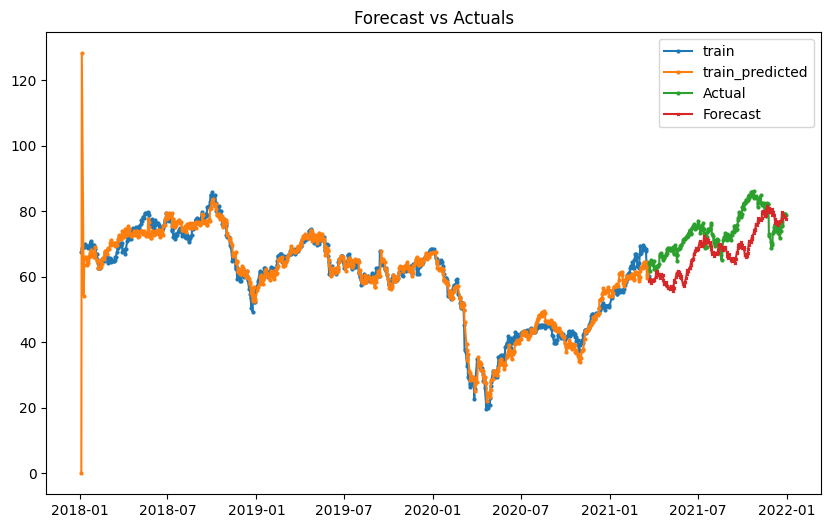

In [12]:
# Decompose the train data
stl = STLForecast(
        train,
        ARIMA,
        model_kwargs=dict(order=best_params["order"], trend=None),
        period=best_params["period"],
        robust=False,
        seasonal=13, 
        trend=365)

result = stl.fit()
forecasted = result.get_prediction(start=len(train), end=len(train) + len(test) - 1).predicted_mean.to_list()
print(result.model_result.aic)

# Inverse the transformation if necessary and plot
# Here, we directly plot the forecasted remainder against the actual remainder for simplicity
plt.figure(figsize=(10, 6))
plt.plot(train.index.to_timestamp(), train.values, label='train', marker='o', markersize=2)
plt.plot(train.index.to_timestamp(), result.model_result.predict(), label='train_predicted', marker='o', markersize=2)
plt.plot(test.index.to_timestamp(), test.values, label='Actual', marker='o', markersize=2)
plt.plot(test.index.to_timestamp(), forecasted, label='Forecast', marker='x', markersize=2)
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [13]:
# Decompose the train data
stl = STLForecast(
        data["out"],
        ARIMA,
        model_kwargs=dict(order=best_params["order"], trend=None),
        period=best_params["period"],
        robust=False,
        seasonal=13, 
        trend=best_params["trend"])

result = stl.fit()
forecasted = result.get_prediction(start=len(data["out"]), end=len(data["out"]) + len(result_df) - 1).predicted_mean.to_list()

result_df["выход"] = forecasted

/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### ML model

In [14]:
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import LinearRegression

In [15]:
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

def calculate_macd(series, short_period, long_period, signal_period):
    ema_short = calculate_ema(series, short_period)
    ema_long = calculate_ema(series, long_period)
    macd = ema_short - ema_long
    signal_line = calculate_ema(macd, signal_period)
    return macd, signal_line

def calculate_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def reconstruct_value(prev_value, logs, type_="diff"):
    if type_ == "diff":
        result = np.exp(logs) + prev_value
    else:
        result = np.exp(logs) * prev_value
    return result

def autoregressive(
    model, 
    out_start, 
    steps,
    categorical,
    numerical,
):
    results = list(out_start)
    for step in range(steps):
        cur_data = pd.DataFrame({"out": results})
        preprocessed = generate_features(cur_data)
        # print(preprocessed)
        X_test = preprocessed[categorical + numerical]

        predictions = model.predict(X_test.iloc[-1:])
        predictions = np.exp(predictions[0]) * results[-1]
        results.append(predictions)
    
    return results


#### minimum for feature generation
minima_length = 30
def generate_features(data):
    # Feature engineering
    data = data.copy()
    for lag in range(1, 30, 5):
        data[f'log_lag0_lag{lag}'] = np.log(data['out'] / data['out'].shift(lag))
    for ema_range in [5, 10, 20, 30]:
        data[f'ema_{ema_range}'] = calculate_ema(data['out'], ema_range)
    macd, signal = calculate_macd(data['out'], 12, 26, 9)
    data['macd'] = macd
    data['macd_signal'] = signal
    for rsi_range in [5, 10, 20, 30]:
        data[f'rsi_{rsi_range}'] = calculate_rsi(data['out'], rsi_range)
    data["prev_value"] = data["out"].shift(1)

    # Dropping rows with NaNs caused by the indicators
    return data.dropna()

def generate_target(data, step=1):
    data = data.copy()
    data["target"] = np.log(data["out"].shift(-step) / data["out"])
    return data.dropna()

preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

# Splitting the dataset again, now with new features
### данные вверх ногами, поэтому такая путаница
split_point = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:split_point]
test_data = preprocessed_data[split_point:]

# Defining new features and target
categorical = ["dir"]
categorical = []
numerical = preprocessed_data.columns.drop(["dir", "out", "target", "prev_value"]).tolist()
X_train, y_train = train_data[categorical + numerical], train_data['target']
X_test, y_test = test_data[categorical + numerical], test_data['target']

# Initialize and fit the CatBoostRegressor
model = CatBoostRegressor(verbose=False)
model.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=100,
    cat_features=categorical, 
    eval_set=(X_test, y_test), 
    verbose=True
)
# model = LinearRegression()
# model.fit(X_train, y_train)

# Predicting and evaluating again
predictions = model.predict(X_test)
mse = mean_squared_error(
    reconstruct_value(test_data["out"], y_test, type_=""), 
    reconstruct_value(test_data["out"], predictions, type_="")
)
print(f'Mean Squared Error with Feature Engineering: {mse}')


Learning rate set to 0.048933
0:	learn: 0.0308057	test: 0.0196683	best: 0.0196683 (0)	total: 54.9ms	remaining: 54.9s
1:	learn: 0.0305554	test: 0.0196748	best: 0.0196683 (0)	total: 58.8ms	remaining: 29.4s
2:	learn: 0.0303181	test: 0.0196857	best: 0.0196683 (0)	total: 61.8ms	remaining: 20.5s
3:	learn: 0.0301685	test: 0.0196851	best: 0.0196683 (0)	total: 66.3ms	remaining: 16.5s
4:	learn: 0.0299152	test: 0.0196920	best: 0.0196683 (0)	total: 69.4ms	remaining: 13.8s
5:	learn: 0.0296582	test: 0.0196911	best: 0.0196683 (0)	total: 71.9ms	remaining: 11.9s
6:	learn: 0.0294875	test: 0.0196972	best: 0.0196683 (0)	total: 73.5ms	remaining: 10.4s
7:	learn: 0.0292787	test: 0.0197029	best: 0.0196683 (0)	total: 75.4ms	remaining: 9.35s
8:	learn: 0.0291147	test: 0.0197053	best: 0.0196683 (0)	total: 77.1ms	remaining: 8.48s
9:	learn: 0.0289398	test: 0.0197244	best: 0.0196683 (0)	total: 78.7ms	remaining: 7.79s
10:	learn: 0.0287578	test: 0.0197202	best: 0.0196683 (0)	total: 79.9ms	remaining: 7.18s
11:	learn: 0

### вывод результатов

In [18]:
test_data.index

PeriodIndex(['2021-03-30', '2021-03-31', '2021-04-01', '2021-04-02',
             '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
             '2021-04-09', '2021-04-12',
             ...
             '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
             '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-27',
             '2021-12-28', '2021-12-29'],
            dtype='period[D]', name='date', length=195)

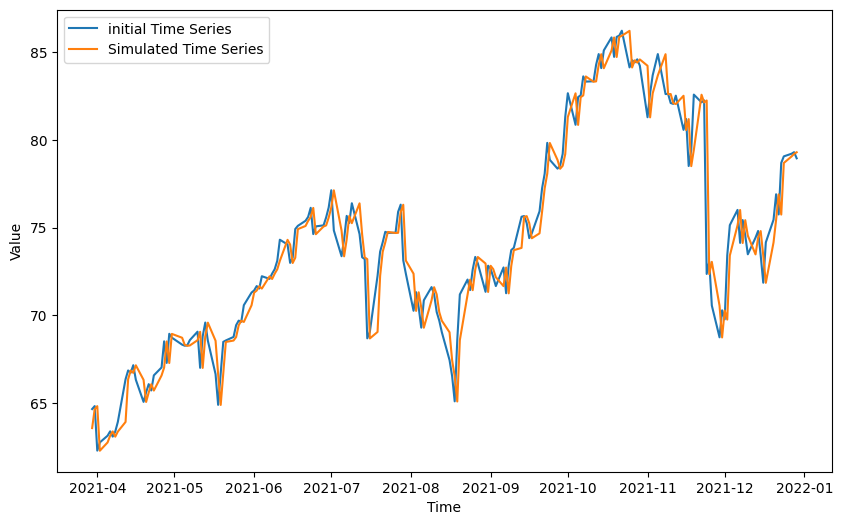

In [19]:
## с коррекцией

plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), reconstruct_value(test_data["out"], y_test, type_=""), label='initial Time Series')
plt.plot(test_data.index.to_timestamp(), reconstruct_value(test_data["out"], predictions, type_=""), label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

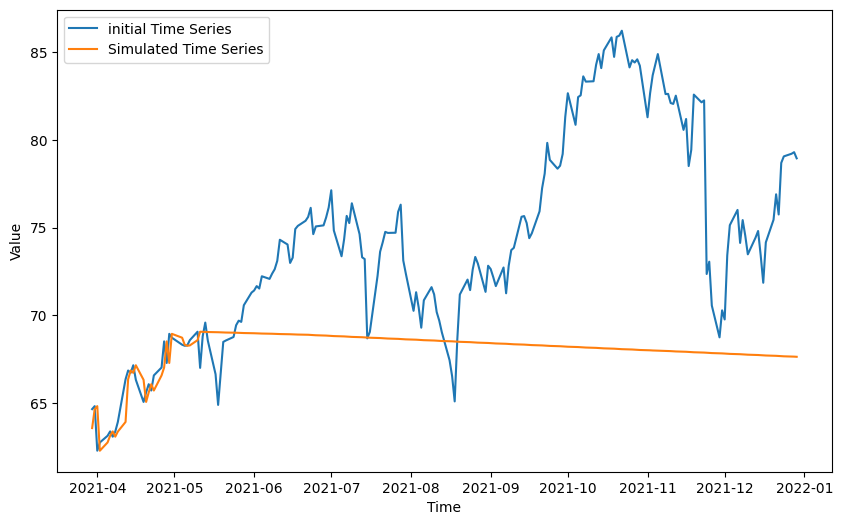

In [20]:
## В авторегрессии

result = autoregressive(
    model, 
    test_data.out.iloc[:minima_length], 
    steps = len(test_data) - minima_length,
    categorical=categorical,
    numerical=numerical,
)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index.to_timestamp(), reconstruct_value(test_data["out"], y_test, type_=""), label='initial Time Series')
plt.plot(test_data.index.to_timestamp(), result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [21]:
mean_squared_error(
    reconstruct_value(test_data["out"], y_test, type_=""), 
    result
)

66.42632738587103

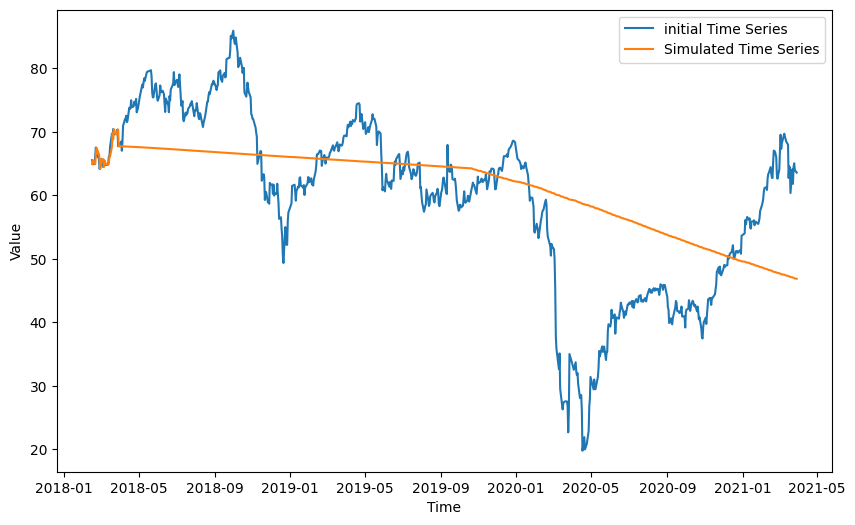

In [23]:
## В авторегрессии

result = autoregressive(
    model, 
    train_data["out"].iloc[:minima_length], 
    steps = len(train_data) - minima_length,
    categorical=categorical,
    numerical=numerical,
)

plt.figure(figsize=(10, 6))
plt.plot(train_data.index.to_timestamp(), reconstruct_value(train_data["out"], y_train, type_=""), label='initial Time Series')
plt.plot(train_data.index.to_timestamp(), result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Выводы

Данных недостаточно для работы более менее хорошей мль модели. Однако статистические модели, вполне можно потроить

In [24]:
preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

categorical = ["dir"]
categorical = []
numerical = preprocessed_data.columns.drop(["dir", "out", "target", "prev_value"]).tolist()
preprocessed_data = preprocessed_data[categorical + numerical]

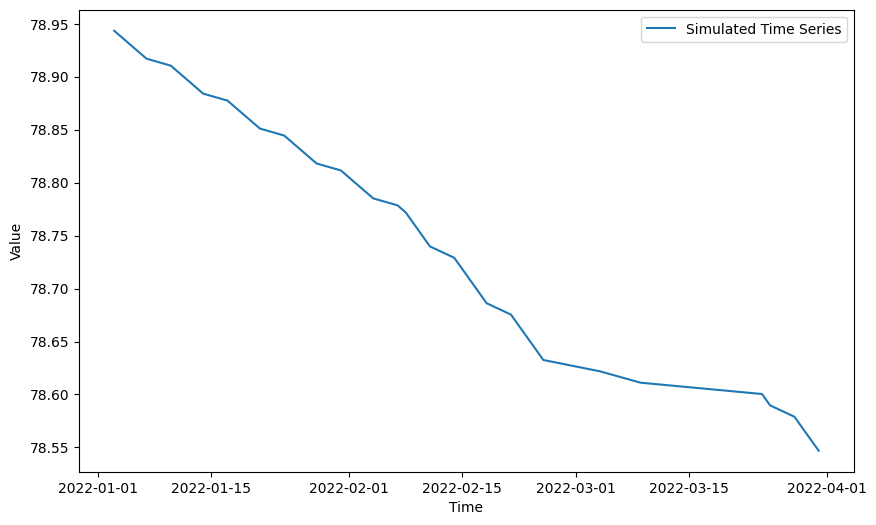

In [25]:
result = autoregressive(
    model, 
    data["out"].iloc[-minima_length:], 
    steps = len(result_df),
    categorical=categorical,
    numerical=numerical,
)
result = result[-len(result_df):]

plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result, label='Simulated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [26]:
# result_df["выход"] = result

### Теперь предскажем направление

In [28]:
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

def calculate_macd(series, short_period, long_period, signal_period):
    ema_short = calculate_ema(series, short_period)
    ema_long = calculate_ema(series, long_period)
    macd = ema_short - ema_long
    signal_line = calculate_ema(macd, signal_period)
    return macd, signal_line

def calculate_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def reconstruct_value(prev_value, logs, type_="diff"):
    if type_ == "diff":
        result = np.exp(logs) + prev_value
    else:
        result = np.exp(logs) * prev_value
    return result

#### minimum for feature generation
minima_length = 30
def generate_features(data):
    # Feature engineering
    data = data.copy()
    for lag in range(1, 30, 1):
        data[f'log_lag0_lag{lag}'] = np.log(data['out'] / data['out'].shift(lag))
    for ema_range in [5, 10, 20, 30]:
        data[f'ema_{ema_range}'] = calculate_ema(data['out'], ema_range)
    macd, signal = calculate_macd(data['out'], 12, 26, 9)
    data['macd'] = macd
    data['macd_signal'] = signal
    for rsi_range in [5, 10, 20, 30]:
        data[f'rsi_{rsi_range}'] = calculate_rsi(data['out'], rsi_range)
    for lag in range(1, 30, 1):
        data[f'dir_lag{lag}'] = data['dir'].shift(lag)

    # Dropping rows with NaNs caused by the indicators
    return data.dropna()

def generate_target(data, step=1):
    data = data.copy()
    data["target_class"] = data["dir"].shift(-1)
    return data.dropna()

def autoregressive(
    model_class,
    out_start, 
    price_prediction,
    steps,
    categorical,
    numerical,
):
    results = list(out_start["out"])
    results_class = list(out_start["dir"])
    for step in range(steps):
        cur_data = pd.DataFrame({"out": results, "dir": results_class})
        preprocessed = generate_features(cur_data)
        # print(preprocessed)
        X_test = preprocessed[categorical + numerical]

        predictions_class = model_class.predict(X_test.iloc[-1:])
        results.append(price_prediction[step])
        results_class.append(predictions_class[0])
    return results_class

preprocessed_data = generate_features(data)
preprocessed_data = generate_target(preprocessed_data, step=1)

split_point = int(len(preprocessed_data) * 0.8)
train_data = preprocessed_data[:split_point]
test_data = preprocessed_data[split_point:]

# Defining new features and target
categorical = preprocessed_data.filter(like="dir").columns.tolist()
numerical = preprocessed_data.columns.drop(["out", "target_class"] + categorical).tolist()
X_train, y_train = train_data[categorical + numerical], train_data['target_class']
X_test, y_test = test_data[categorical + numerical], test_data['target_class']

# Initialize and fit the CatBoostRegressor
model_cat = CatBoostClassifier(verbose=False)
model_cat.fit(
    X_train, 
    y_train, 
    early_stopping_rounds=100,
    cat_features=categorical, 
    eval_set=(X_test, y_test), 
    verbose=True
)
# model = LinearRegression()
# model.fit(X_train, y_train)

# Predicting and evaluating again
predictions = model_cat.predict(X_test)

label_to_idx = {
    "л": 1,
    "ш": 0,
}
mse = f1_score(
    y_test.map(label_to_idx),
    list(map(lambda x: label_to_idx[x], predictions))
)
print(f'F1 score with Feature Engineering: {mse}')

Learning rate set to 0.029765
0:	learn: 0.6908265	test: 0.6936956	best: 0.6936956 (0)	total: 7.69ms	remaining: 7.68s
1:	learn: 0.6882070	test: 0.6930186	best: 0.6930186 (1)	total: 9.3ms	remaining: 4.64s
2:	learn: 0.6858039	test: 0.6937705	best: 0.6930186 (1)	total: 10.8ms	remaining: 3.59s
3:	learn: 0.6835919	test: 0.6946814	best: 0.6930186 (1)	total: 12.7ms	remaining: 3.16s
4:	learn: 0.6820598	test: 0.6942649	best: 0.6930186 (1)	total: 14.3ms	remaining: 2.84s
5:	learn: 0.6802632	test: 0.6939332	best: 0.6930186 (1)	total: 15.9ms	remaining: 2.63s
6:	learn: 0.6781988	test: 0.6924159	best: 0.6924159 (6)	total: 18ms	remaining: 2.56s
7:	learn: 0.6761414	test: 0.6922024	best: 0.6922024 (7)	total: 20.6ms	remaining: 2.56s
8:	learn: 0.6738715	test: 0.6917175	best: 0.6917175 (8)	total: 22.4ms	remaining: 2.47s
9:	learn: 0.6720037	test: 0.6917891	best: 0.6917175 (8)	total: 24.2ms	remaining: 2.4s
10:	learn: 0.6703762	test: 0.6920070	best: 0.6917175 (8)	total: 25.9ms	remaining: 2.33s
11:	learn: 0.668

In [29]:
result = autoregressive(
    model_cat,
    data.iloc[-minima_length:], 
    result_df["выход"].tolist(),
    steps = len(result_df),
    categorical=categorical,
    numerical=numerical,
)
result = result[-len(result_df):]

In [30]:
result_df["направление"] = result
result_df["направление"] = result_df["направление"].map(label_to_idx)

In [31]:
import json
data1 = result_df["выход"].tolist()
data2 = result_df["направление"].tolist()
with open('forecast_value.json', 'w') as file:
    json.dump(data1, file)
with open('forecast_class.json', 'w') as file:
    json.dump(data2, file)